In [1]:
import os
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
matplotlib.rcParams['figure.figsize'] = [30, 10]
from matplotlib.backends.backend_pdf import PdfPages

def percentile(n):
    def percentile_(x):
        return np.percentile(x, n)
    percentile_.__name__ = 'percentile_%s' % n
    return percentile_

In [3]:
hfc = pd.read_table("../data/hfc_pubEpitopes.csv", index_col = 0,sep=',')
hfc.columns = hfc.columns.str.replace("HIV3_plate_","p")
hfc = hfc.loc[:,~hfc.columns.str.contains("BEADS_ONLY")]
wt_set = set([index.split("_")[0] for index in hfc.index])

In [4]:
ahfc = hfc.loc[~hfc.index.str.contains("mer_"),:].copy()
ahfc.loc[:,"wildtype"] = list(ahfc.index.str.split("_").str[0])
ahfc.loc[:,"scan"] = list(ahfc.index.str.split("_").str[1])
ahfc.loc[:,"sequence"] = list(ahfc.index.str.split("_").str[2])

In [5]:
ahfc = pd.melt(ahfc, id_vars=["wildtype", "scan", "sequence"], var_name="sample", value_name='hfc')
ahfc.shape

(12943037, 5)

In [6]:
# EXCLUDE SAMPLE-WILDTYPE PAIRS THAT HAVE 0 IN ALL PEPTIDES
wt_sample_aggregation = ahfc.groupby(["wildtype","sample"], as_index = False).agg({'hfc': np.max})
ahfc = ahfc.join(wt_sample_aggregation.set_index(["wildtype","sample"]), on = ["wildtype","sample"], rsuffix='_max')
ahfc = ahfc.loc[ahfc["hfc_max"]>50,:]
ahfc.shape

(407087, 6)

In [7]:
# EXCLUDE SAMPLE-WILDTYPE PAIRS THAT HAVE 0 IN WILDTYPE
wt_df = ahfc.loc[ahfc["scan"] == "wildtype",["wildtype","sample","hfc"]]
ahfc = ahfc.join(wt_df.set_index(["wildtype","sample"]), on = ["wildtype","sample"], rsuffix='_wt')
ahfc = ahfc.loc[ahfc["hfc_wt"]>30,:]
ahfc.shape

(271872, 7)

In [8]:
# EXCLUDE SAMPLE-WILDTYPE PAIRS WHERE THE WILDTYPE REACTIVITY IS NOT THE MAX REACTIVITY

wt_sample_aggregation = ahfc.groupby(["wildtype","sample"], as_index = False).agg({'hfc': percentile(90)})
ahfc = ahfc.join(wt_sample_aggregation.set_index(["wildtype","sample"]), on = ["wildtype","sample"], rsuffix='_90percentile')
ahfc = ahfc.loc[ahfc["hfc_wt"]>=ahfc["hfc_90percentile"],:]
ahfc.shape

(37858, 8)

In [9]:
#  how many ala_scans available
ahfc.groupby(["wildtype","sample"]).agg(max).shape

(710, 6)

In [10]:
pos_feat = pd.DataFrame(columns=["seqID", "sample", "pos", "aa", "wt_hfc", "pep_max", "ala_hfc"])
c = 0
numberofseqs = len(wt_set) #544
#numberofseqs = 10

for ix, row in ahfc.iterrows():
    if row.scan == "wildtype" :
        if c > numberofseqs-1:
            break
        c = c+1
        pos = 0
        sample = row["sample"]
        seqID = row.wildtype
        seq = row.sequence
        seq_len = len(seq)
        for aa in seq :
            idx = seqID + "_" + sample + "_" + str(pos)
            pos_feat.loc[idx, "seqID"] = seqID
            pos_feat.loc[idx, "sample"] = sample
            pos_feat.loc[idx, "pos"] = pos
            pos_feat.loc[idx, "aa"] = aa
            pos_feat.loc[idx, "wt_hfc"] = row.hfc_wt
            pos_feat.loc[idx, "pep_max"] = row.hfc_max
            pos_feat.loc[idx, "ala_hfc"] = 0
            pos = pos + 1
    else:
        aaa_pos = int(row.scan[1:])-1
        reactivity = row.hfc
        for pos_int in range(aaa_pos, aaa_pos+3):
            idx = seqID + "_" + sample + "_" + str(pos_int)
            if pos_int==0 or pos_int==seq_len-1:
                pos_feat.loc[idx, "ala_hfc"] = pos_feat.loc[idx, "ala_hfc"]  + (reactivity)
            elif pos_int==1 or pos_int==seq_len-2:
                pos_feat.loc[idx, "ala_hfc"] = pos_feat.loc[idx, "ala_hfc"]  + (reactivity/2)
            else:
                pos_feat.loc[idx, "ala_hfc"] = pos_feat.loc[idx, "ala_hfc"]  + (reactivity/3)
    
        
pos_feat["Diff_to_WT"] = pos_feat["wt_hfc"]-pos_feat["ala_hfc"]
pos_feat["Diff_to_pepMax"] = pos_feat["pep_max"]-pos_feat["ala_hfc"]

seqIDs = pos_feat.seqID.unique()

In [11]:
pos_feat.Diff_to_pepMax = pos_feat.Diff_to_pepMax.astype(float)
pos_feat.Diff_to_WT = pos_feat.Diff_to_WT.astype(float)
pos_feat.wt_hfc = pos_feat.wt_hfc.astype(float)
pos_feat.ala_hfc = pos_feat.ala_hfc.astype(float)

In [ ]:
pos_feat.shape

(29632, 9)

In [ ]:
#pos_feat.to_csv("ala_scan.csv")
#pos_feat = pd.read_table("ala_scan.csv", index_col = 0, sep = ",")
pos_feat["seqID"] = pos_feat["seqID"].astype(str)

In [17]:
ala_scan = pos_feat.pivot_table(index='pos',
                    columns=['seqID', 'sample'], 
                    values='Diff_to_pepMax',
                    aggfunc='first')

In [19]:
# only full length wildtypes
#ala_scan = ala_scan.loc[:,~ala_scan.loc[55,:].isna()]

In [20]:
#normalize to same height
ala_min = ala_scan.quantile(0.1)
ala_max = ala_scan.quantile(0.9)
ala_scan = (ala_scan-ala_min)/(ala_max-ala_min)

ala_scan = ala_scan.fillna(0)
ala_scan[ala_scan<0] = 0
ala_scan[ala_scan>1] = 1


In [21]:
maxcol_cutoff = 0.9 # maximum considered for centering and epitope
middle_max = 0.85 # if more than 1 position is below this value in the middle of two maxima, it will be considered as two epitopes

def shift_cols_max(col, center):
    max_indeces = col.loc[col>maxcol_cutoff].index
    max_pos = int(np.median(max_indeces))
    return(col.shift(center-max_pos, fill_value=0))

def has_only_one_epitope(col):
    max_indeces = col.loc[col>maxcol_cutoff].index
    # returns false if more than one position between the outmost maxima is less than middle_max% of the max
    return(sum(col[max_indeces.min():max_indeces.max()+1]<middle_max)<2)

In [22]:
ala_scan_oneEpis = ala_scan.iloc[:,[has_only_one_epitope(ala_scan[x]) for x in ala_scan.columns]]
len(ala_scan_oneEpis.columns)

288

In [23]:
ala_scan_shifted = ala_scan_oneEpis.apply(lambda x: shift_cols_max(x,28), axis = 0)

width: 14


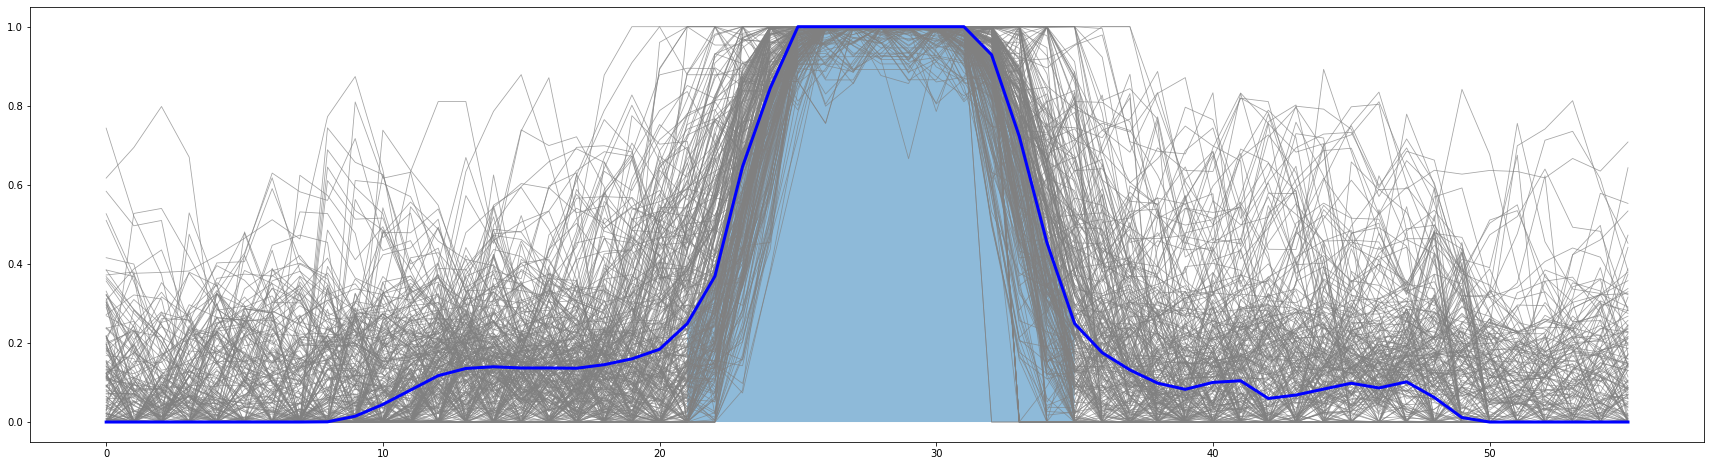

In [24]:
area_color = 0.8

for column in ala_scan_shifted:
    plt.plot(ala_scan_shifted.index, ala_scan_shifted[column], linewidth=0.8, alpha=0.7, color = "grey")
    
ala_mean = ala_scan_shifted.median(axis=1)
fullarea = np.trapz(ala_mean, dx=1)
i90 = 0
for i in range(28):
    subarea = np.trapz(ala_scan_shifted.loc[0+i:56-i,:].median(axis=1), dx=1) 
    if subarea/fullarea > area_color:
        i90 = i + 1
        
print("width:", str(56-(2*i90)))
plt.plot(ala_mean.index, ala_mean, linewidth=3,  color = "blue")
plt.fill_between(np.arange(i90, 57-i90), ala_scan_shifted.loc[i90:56-i90,:].median(axis=1), alpha=0.5)
plt.show()

In [25]:
i90 = 0
for i in range(28):
    subarea = np.trapz(ala_scan_shifted.loc[0+i:56-i,:].mean(axis=1), dx=1)    
    print(i, subarea/fullarea, str(56-(2*i)))
    if subarea/fullarea > 0.9:
        i90 = i + 1

0 1.157567495368087 56
1 1.1531372949277392 54
2 1.1445440586726194 52
3 1.1358707964089856 50
4 1.126750986636823 48
5 1.1170140074705932 46
6 1.1066539276597103 44
7 1.095044244649765 42
8 1.0810151997677184 40
9 1.0650304725417898 38
10 1.0481738470647242 36
11 1.030418023216218 34
12 1.0113148157685485 32
13 0.9911567522037009 30
14 0.9702183711707442 28
15 0.9487768994277901 26
16 0.9269151772025589 24
17 0.9047274755789255 22
18 0.8811891763947467 20
19 0.8543882796868064 18
20 0.8228767738466404 16
21 0.7839754492346633 14
22 0.7316823532315611 12
23 0.6554531334499055 10
24 0.548881540201506 8
25 0.4190054287630345 6
26 0.28017640384684156 4
27 0.14025480561909295 2


In [ ]:
# visualization per wildtype

seqIDs = pos_feat.seqID.unique()
matplotlib.rcParams['figure.figsize'] = [30, 8]

with PdfPages('../AlanineScan_DiffToWT.pdf') as pdf:
    for s in seqIDs:
        df = pos_feat[pos_feat["seqID"] == s]
        fs = pd.unique(df['sample'])[0]
        seq = list(df.loc[df["sample"] == fs, "aa"])
        plt.figure(s)
        #a = sns.lineplot(data=pos_feat[pos_feat["seqID"] == s], x='pos', y='Diff_to_pepMax', hue='sample', legend = False)
        a = sns.lineplot(data=pos_feat[pos_feat["seqID"] == s], x='pos', y='Diff_to_WT', hue='sample', legend = False)
        ax = a.twiny()
        #ax = sns.lineplot(data=pos_feat[pos_feat["seqID"] == s], x='pos', y='wt_hfc', hue='sample', legend = False)
        a.set(title = str(s))
        ax.set_xticks(range(len(seq)))
        ax.set_xticklabels(seq)
        ax.set(xlabel=None)
        pdf.savefig()
        plt.close()
    
    d = pdf.infodict()
    d['Title'] = 'Alanine Scan from Public Epitope Dataset'
    d['Author'] = 'Dr. Anna Liebhoff'
    d['Subject'] = 'Collection of vizualized Public Epitopes'
    d['CreationDate'] = datetime.datetime.today()
    d['ModDate'] = datetime.datetime.today()